# Case Study

Jack Dean, Charles Dotson, and Rodrigo Petricioli  
ISE 447 - Financial Optimization  
Lehigh Univerisity

In [1]:
'''
Package Imports
'''
import pandas as pd
import numpy as np
import pulp
from pulp import *
import datetime
import matplotlib.pyplot as plt

import FinOpsCodeDeck as finops

## Provided Data

A municipality sends the following liability stream (in millions of dollars)

| Date Due | Amount |  
| -- | -- |
| 12/15/2022 | 11 |  
|  6/15/2023 |  9 |  
| 12/15/2023 |  8 |  
|  6/15/2024 |  7 |  
| 12/15/2024 |  9 |  
|  6/15/2025 | 10 |  
| 12/15/2025 |  9 |  
|  6/15/2026 | 12 |  
| 12/15/2026 |  9 |  
|  6/15/2027 |  6 |  
| 12/15/2027 |  5 |  
|  6/15/2028 |  7 |  
| 12/15/2028 |  9 |  
|  6/15/2029 |  7 |  
| 12/15/2029 |  8 |  
|  6/15/2030 |  7 |  

## Problem 1

Determine the current term structure of treasury rates (see textbook Section 3.4 or other resources that you can find), and find the present value, duration, and convexity of the stream of liabilities. Please explain the main steps followed in your calculations.  Use real world data.

In [2]:
'''
Data Import for Current Term Structure
---
Imports all active treasury bonds data, time indexes them by year
'''
term_structure_df = pd.read_excel('Table.xlsx', sheet_name='Bills Bonds and Notes')
term_structure_df['px_last'] = [i if i>=5 else 100 - i for i in term_structure_df['ASKED'].to_list()]
term_structure_df['ttm'] = [(i - datetime.datetime.now())/datetime.timedelta(days=365) for i in term_structure_df['MATURITY']]

In [3]:
'''
Bootstrap yield curve
---
begins with zero-coupon bonds to payout (ttm < 0.5 yrs) & calculates yield
moves to coupon bonds and uses calculated yields to bootstrap further
sorts all bonds into data frame indexed by ttm (by 100th of a year)
NOTE: Averages yields for the same time period
NOTE: assumes yield of period prior if yield for desired period does not exist
'''

'''short term rates'''
mats = []
round_to = 2
for bond_tenor in term_structure_df[term_structure_df['ttm'] <= 0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    cpn = bond['COUPON']/2
    ttm = bond['ttm']
    px = bond['px_last']
    mats.append([np.round(ttm,round_to),np.log((100 + cpn) / bond['px_last']) / bond['ttm']])
rates = pd.DataFrame(mats, columns=['ttm','rate']).set_index('ttm').groupby('ttm').mean()

'''longer term rates'''
for bond_tenor in term_structure_df[term_structure_df['ttm']>=0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    px = bond['px_last']
    ttm = bond['ttm']
    cpn = bond['COUPON']/2
    pmts = int(np.ceil(ttm * 2))
    cfs = [cpn if i+1<pmts else 100 + cpn for i in range(pmts)]
    cfs_idx = [np.round(ttm-i*0.5, round_to) for i in reversed(range(pmts))]
    known_rates = [rates[:cfs_idx[i]].iloc[-1,0] for i in range(pmts-1)]
    val = px - sum([cpn * np.exp((-1) * known_rates[i] * cfs_idx[i]) for i in range(pmts-1)])
    yld = (-1) * (np.log(val / (100+cpn)) / cfs_idx[pmts-1])
    add_df = pd.DataFrame([np.round(ttm, round_to), yld], index=['ttm','rate']).transpose().set_index('ttm')
    rates = pd.concat([rates,add_df],ignore_index=False)
    rates = rates.groupby('ttm').mean()

Text(0, 0.5, 'Yield in Percentage Points')

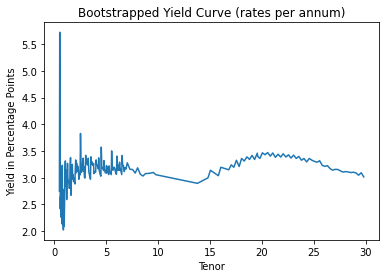

In [4]:
'''
plot yield curve
---
plots yield curve in percentage points
'''
plt.plot(rates[0.5:] * 100)
plt.title('Bootstrapped Yield Curve (rates per annum)')
plt.xlabel('Tenor')
plt.ylabel('Yield in Percentage Points')

In [24]:
data_prompt = pd.read_excel('Table.xlsx', sheet_name='PromptUse', index_col = 'DateDue')
data_prompt['ttm'] = np.round((data_prompt.index - datetime.datetime.now()) / datetime.timedelta(days=365), round_to)

r = []
for ttm in data_prompt['ttm']:
    r.append(rates[:ttm].iloc[-1,0])
data_prompt['rates'] = r

npv = sum([data_prompt.iloc[i,0]*np.exp((-1) * data_prompt.iloc[i,1] * data_prompt.iloc[i,2]) for i in range(len(data_prompt))])
dur = sum([data_prompt.iloc[i,1]*data_prompt.iloc[i,0]*np.exp((-1) * data_prompt.iloc[i,1] * data_prompt.iloc[i,2]) for i in range(len(data_prompt))])
con = sum([data_prompt.iloc[i,1]*(data_prompt.iloc[i,1]+1)*data_prompt.iloc[i,0]*np.exp((-1) * (data_prompt.iloc[i,1] + 2 ) * data_prompt.iloc[i,2]) for i in range(len(data_prompt))])

print('The Net Present Value of the Liabilities is ${:.2f} million dollars'.format(npv/1000))
print('The Macauley Duration of the Liability stream is {:.2f} years'.format(dur/npv))
print('The Convexity of the Liability stream is {:.2f}'.format(con/npv))

The Net Present Value of the Liabilities is $116.94 million dollars
The Macauley Duration of the Liability stream is 3.98 years
The Convexity of the Liability stream is 23.48


## Problem 2

Identify *at least* 30 fixed-income assets that are suitable to construct a dedicated bond portfolio for the municipality liabilities that you have been given. Use assets that are considered risk-free; for example, US government non-callable treasury bonds, treasury bills, or treasury notes. Display in an appropriate table the main characteristics of the bonds you choose. Namely, prices, coupon rates, maturity dates, face value).

In [25]:
'''
code block
'''
term_structure_df

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD,px_last,ttm
0,2022-05-05,0.000,0.068,0.058,0.025,0.0580,99.942,0.000598
1,2022-05-10,0.000,0.085,0.075,-0.018,0.0760,99.925,0.014296
2,2022-05-12,0.000,0.153,0.143,0.005,0.1450,99.857,0.019776
3,2022-05-15,1.750,100.020,100.024,-0.004,-0.6005,100.024,0.027995
4,2022-05-15,2.125,100.024,100.030,-0.002,-0.6944,100.030,0.027995
...,...,...,...,...,...,...,...,...
356,2051-02-15,1.875,76.260,76.280,-2.006,3.0940,76.280,28.803338
357,2051-05-15,2.375,86.102,86.122,-2.058,3.0890,86.122,29.047173
358,2051-08-15,2.000,79.056,79.076,-2.016,3.0810,79.076,29.299228
359,2051-11-15,1.875,76.260,76.280,-2.01,3.0720,76.280,29.551283


## Problem 3

Formulate a linear programming model to find the lowest cost bond dedicated portfolio that covers the stream of liabilities. To eliminate the possibility of any interest risk, assume that a 0% reinvestment rate on cash balances carried out from one date to the next. Assume no short selling of bonds is allowed. What is the cost of your portfolio? How does this cost compares with the NPV of the liabilities? What is the composition of the portfolio?

In [7]:
'''
code block
'''

'\ncode block\n'

## Problem 4

Use the linear programming sensitivity analysis information to determine the term structure of interest rates implied by the optimal bond portfolio you found in the previous question. Use a plot to compare these rates with the current term structure of treasury rates you found in the first question.

In [8]:
'''
code block
'''

'\ncode block\n'

## Problem 5

Formulate a linear programming model to find the lowest cost bond immunized portfolio that matches the present value, duration, and convexity of a stream of liabilities. Assume that no short rates are allowed. What is the cost of your portfolio? How much would you save by using this immunization strategy instead of the dedication one? Is your portfolio immunized against non-parallel shifts in the term structure? Explain why or why not.

In [9]:
'''
code block
'''

'\ncode block\n'

## Problem 6

Combine a cash matching strategy (dedication) for the liabilities for the first three years and an immunization strategy based on matching present value, duration and convexity for the liabilities during the last five years. Compare the characteristics of the three bond portfolios you have obtained. Explain which one you think is the best one and why.

In [10]:
'''
code block
'''

'\ncode block\n'

## Problem 7

The municipality would like to make a second bid (find a different portfolio of bonds). What is your best dedicated portfolio of risk-free bonds you can create *if short sales are allowed*? Did you find arbitrage opportunities? Did you take into consideration the bid-ask spread of the bonds? How would you take them in consideration and what is the result? Did you set limits in the transaction amounts? Discuss the practical feasibility of your solutions.

In [11]:
'''
code block
'''

'\ncode block\n'

## Problem 8

Consider proposing a new portfolio of bonds using any additional consideration or change to the model that you see fit. For example, can you do something to make your portfolio of bonds immune to nonparallel changes in the term structure. Is there a better way to combine the techniques you used before. Explain clearly what you do and your results.

In [12]:
'''
code block
'''

'\ncode block\n'